# Setup

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

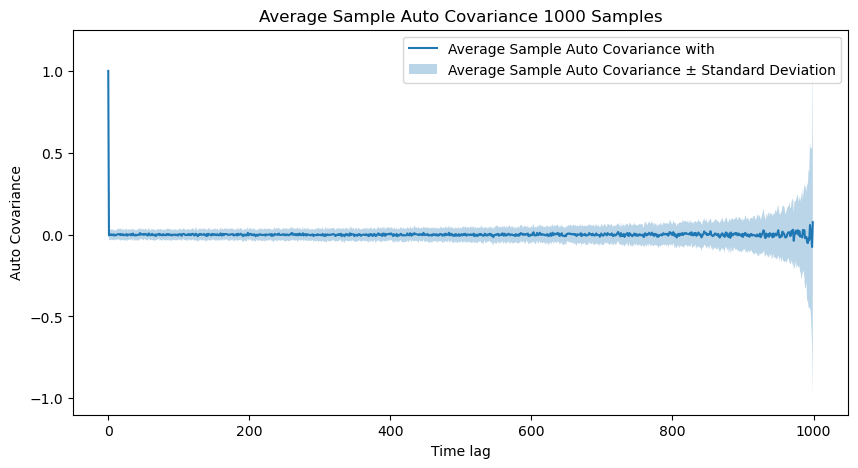

In [6]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
# periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
# freqs = np.linspace(0, 0.5, 200)
# ##


# fig, ax = fig_ax(figsize=(9, 5))

# avg = periodograms.mean(axis=0)
# std = periodograms.std(axis=0)
# ax.plot(freqs, avg, 'k-')
# ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


import numpy as np
import matplotlib.pyplot as plt

N = 1000
num_simulations = 100
sigma_sq = 1.0
fs = 1.0  # sampling frequency

autocovariances = np.zeros((num_simulations, N))

# 100 times iterations
for i in range(num_simulations):
    X = np.random.normal(0, np.sqrt(sigma_sq), N)  # generate gaussian white noise
    for tau in range(N):
        autocovariances[i, tau] = np.mean(X[:N - tau] * X[tau:])



# calculate average and standard deviation
avg_autocov = np.mean(autocovariances, axis=0)
std_autocov = np.std(autocovariances, axis=0)

# plot
plt.figure(figsize=(10, 5))
plt.plot(avg_autocov, label='Average Sample Auto Covariance with ')
plt.fill_between(range(N), avg_autocov - std_autocov, avg_autocov + std_autocov, alpha=0.3, label='Average Sample Auto Covariance ± Standard Deviation')
plt.xlabel('Time lag')
plt.ylabel('Auto Covariance')
plt.legend()
plt.title('Average Sample Auto Covariance '+ str(N) + " Samples")
plt.show()


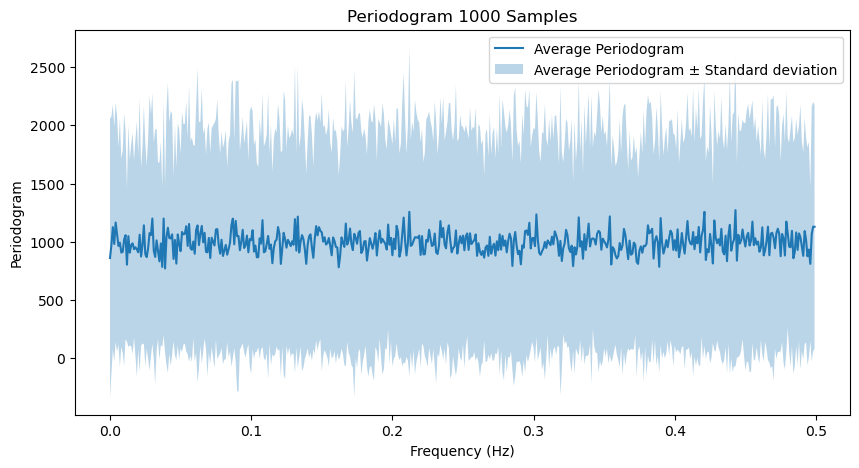

In [7]:
from scipy.fft import fft

periodograms = np.zeros((num_simulations, N))

for i in range(num_simulations):
    X = np.random.normal(0, np.sqrt(sigma_sq), N) 
    F = fft(X)
    periodograms[i] = np.abs(F)**2


# Calculate average periodogram and standard deviation
avg_periodogram = np.mean(periodograms, axis=0)
std_periodogram = np.std(periodograms, axis=0)

# Only take positive frequency
frequencies = np.fft.fftfreq(N, 1/fs)
positive_frequencies = frequencies[:N // 2]
avg_periodogram = avg_periodogram[:N // 2]
std_periodogram = std_periodogram[:N // 2]

# plot
plt.figure(figsize=(10, 5))
plt.plot(positive_frequencies, avg_periodogram, label='Average Periodogram')
plt.fill_between(positive_frequencies, avg_periodogram - std_periodogram, avg_periodogram + std_periodogram, alpha=0.3, label='Average Periodogram ± Standard deviation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Periodogram')
plt.legend()
plt.title('Periodogram '+ str(N) + " Samples")
plt.show()




## Question 9

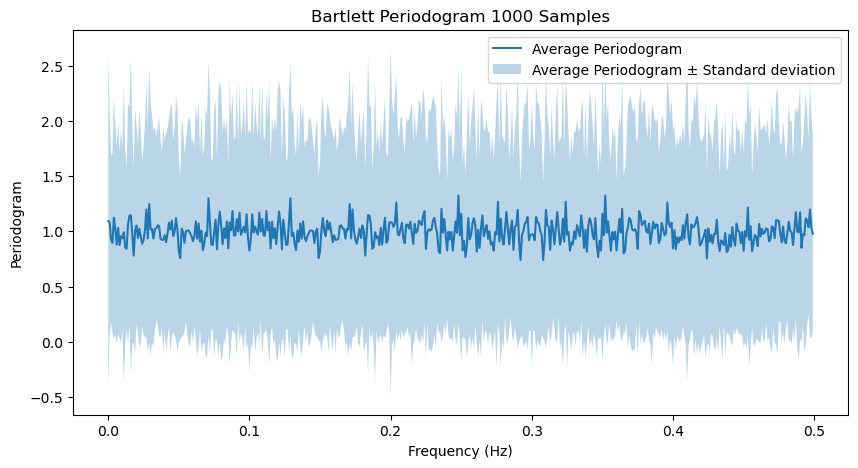

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
N = 1000  # Choose your desired value of N
num_simulations = 100
sigma_sq = 1.0
fs = 1.0  # Sampling frequency
K = 5  # Number of sections for Bartlett's estimate

# Initialize arrays to store results
average_bartlett_periodograms = []

# Create frequency axis
frequencies = np.fft.fftfreq(N, 1/fs)
positive_frequencies = frequencies[:N // 2]

# Perform the experiment for the specified value of N
bartlett_periodograms = np.zeros((num_simulations, N))

for i in range(num_simulations):
    X = np.random.normal(0, np.sqrt(sigma_sq), N)
    section_size = N // K
    section_periodograms = np.zeros((K, N))

    # Divide the signal into K sections and compute the periodogram for each section
    for k in range(K):
        start = k * section_size
        if (k!=K-1):
            end = (k + 1) * section_size
        else:
            end = N
        section = X[start:end]
        section_periodograms[k][start:end]  = np.abs(np.fft.fft(section))**2 / section_size

    # Sum the periodograms from all sections
    bartlett_periodograms[i] = np.sum(section_periodograms, axis=0)

# Average the periodograms from all simulations
average_periodogram = np.mean(bartlett_periodograms, axis=0)[:N // 2]
std_periodogram = np.std(bartlett_periodograms, axis=0)[:N // 2]
average_bartlett_periodograms.append(average_periodogram)

# Plot the results for the specified value of N
plt.figure(figsize=(10, 5))
plt.plot(positive_frequencies, average_periodogram, label='Average Periodogram')
plt.fill_between(positive_frequencies, average_periodogram - std_periodogram, average_periodogram + std_periodogram, alpha=0.3, label='Average Periodogram ± Standard deviation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Periodogram')
plt.legend()
plt.title('Bartlett Periodogram '+ str(N) + " Samples")
plt.show()


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [121]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [122]:
print (str(len(X_train))+":" + str(len(X_train[1])))
print (str(len(y_train)))

print (str(len(X_test))+":" + str(len(X_test[1])))
print (str(len(y_test)))

168:78
168
88:69
88


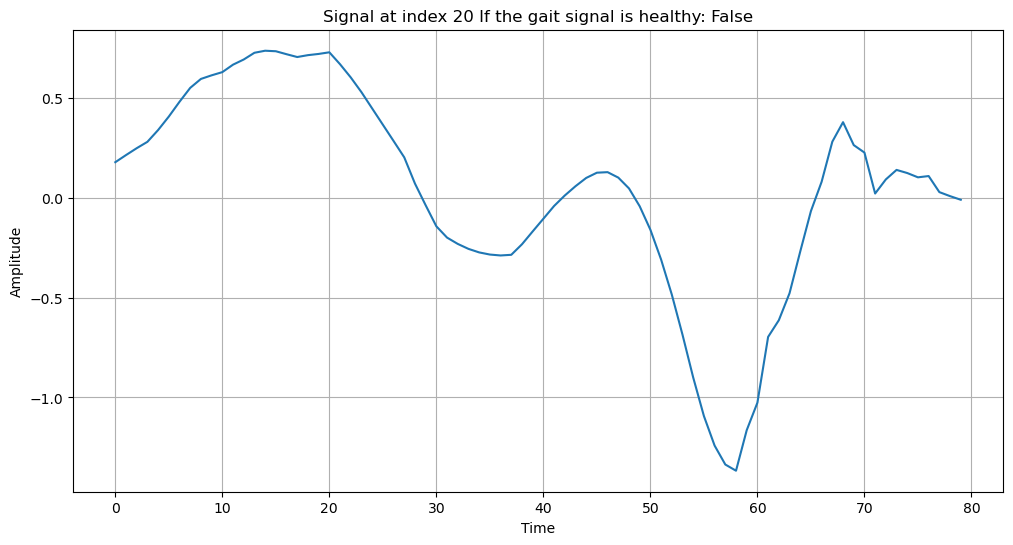

In [126]:
import matplotlib.pyplot as plt

# Choose the index of the signal you want to plot (e.g., 0)
signal_index = 20

# Get the signal from X_train
signal_to_plot = X_train[signal_index]

# Create a time axis for the signal (you may need to adjust this depending on your data)
time_axis = range(len(signal_to_plot))

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis, signal_to_plot)
plt.title(f'Signal at index {signal_index} If the gait signal is healthy: {"True" if y_train[signal_index] == 0 else "False"}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Question 11

In [129]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

def dtw(x, y):
    distance, path = fastdtw(x, y)
    return distance

# Initialize a list to store F-scores for different values of k
f_scores = []

# Define a range of k values to test
k_values = [1, 3, 5, 7, 9]

# Zeros filling
max_length_X_train = max(len(signal) for signal in X_train)
max_length_X_test = max(len(signal) for signal in X_test)
max_length = max(max_length_X_train, max_length_X_test)

X_train_padded = [np.pad(signal, (0, max_length - len(signal)), 'constant') for signal in X_train]
X_test_padded = [np.pad(signal, (0, max_length - len(signal)), 'constant') for signal in X_test]

# Create Stratified K-Fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True)

f_scores_fold = []  # Store F-scores for each fold

for k in k_values:
    print(f"Testing k = {k}")

    for train_index, test_index in kf.split(X_train_padded, y_train):
        X_train_fold, X_val_fold = [X_train_padded[i] for i in train_index], [X_train_padded[i] for i in test_index]
        y_train_fold, y_val_fold = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

        # Initialize K-Neighbors Classifier with the current k value and custom DTW metric
        knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=dtw)
        knn_classifier.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        y_val_pred = knn_classifier.predict(X_val_fold)

        # Calculate the F-score for the fold
        f_score = f1_score(y_val_fold, y_val_pred)
        f_scores_fold.append(f_score)

    # Calculate the average F-score across all folds for the current k value
    avg_f_score = np.mean(f_scores_fold)
    f_scores.append(avg_f_score)

# Find the k value that yields the highest F-score
optimal_k = k_values[np.argmax(f_scores)]
max_f_score = max(f_scores)

# Print the optimal k value and associated F-score
print(f'Optimal number(k): {optimal_k}')
print(f'F-score: {max_f_score:.4f}')


Testing k = 1
Testing k = 3
Testing k = 5
Testing k = 7
Testing k = 9
Optimal number of neighbors (k): 7
Optimal F-score: 0.8555
The optimal number of neighbors and associated F-score have been determined using 5-fold cross-validation.
The selected k value allows the K-Neighbors Classifier to effectively classify healthy and non-healthy steps.


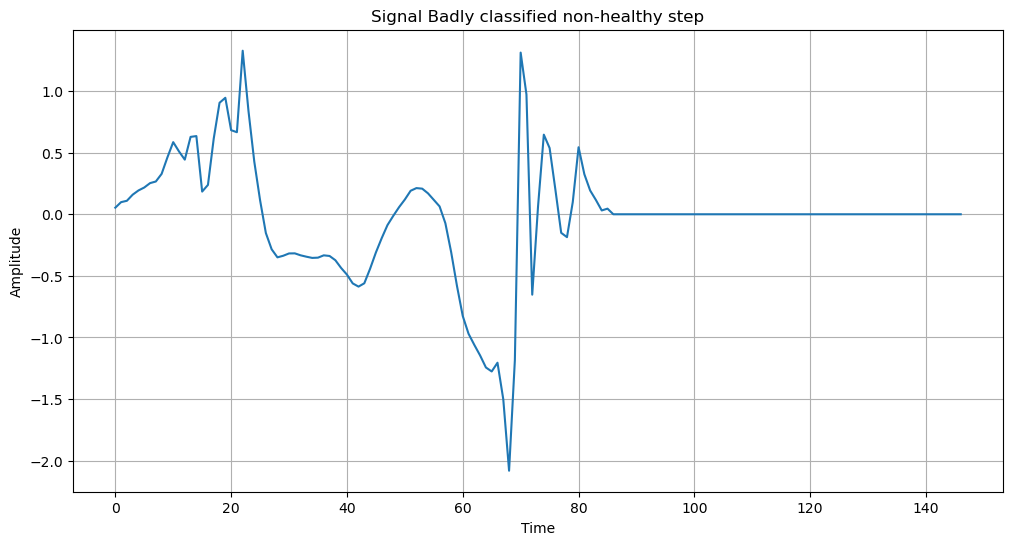

In [150]:
result_1 = []
for i in range(len(y_val_fold)):
    if y_val_fold[i] == 0 and y_val_pred[i] == 1:
        result_1.append(i)
index_Badly_Classified_non_healthy = result_1[0]
# Plot the signal
time_axis = range(len(X_val_fold[index_Badly_Classified_non_healthy]))
plt.figure(figsize=(12, 6))
plt.plot(time_axis, X_val_fold[index_Badly_Classified_non_healthy])
plt.title(f'Signal Badly classified non-healthy step')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

5


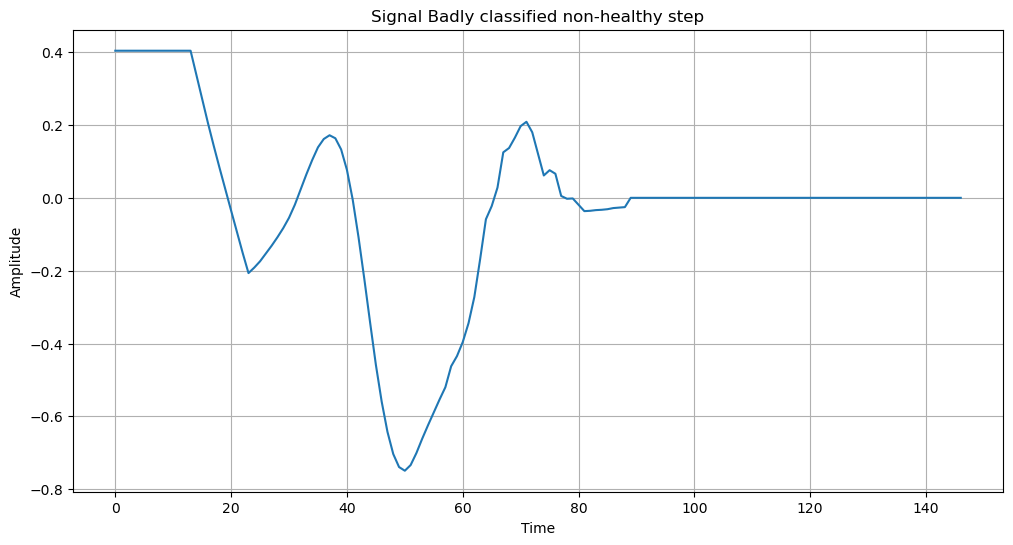

In [151]:
result_2 = []
for i in range(len(y_val_fold)):
    if y_val_fold[i] == 1 and y_val_pred[i] == 0:
        result_2.append(i)
index_Badly_Classified_healthy = result_2[0]
print (index_Badly_Classified_healthy)
# Plot the signal
time_axis = range(len(X_val_fold[index_Badly_Classified_healthy]))
plt.figure(figsize=(12, 6))
plt.plot(time_axis, X_val_fold[index_Badly_Classified_healthy])
plt.title(f'Signal Badly classified healthy step')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()